# Switching dynamics

In the case of the switching dynamics we assume that the reward probability $p_{t}$ changes suddenly but is otherwise constant. We can express the dynamics of reward probabilities as 
\begin{equation}
    p_{t} \sim \left\{ \begin{array}{cc}
        Beta(1, 1) & \textrm{for } j_{t-1} = 1  \\
        \delta(p_{t} - p_{t-1}) & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $Beta(1, 1)$ denotes beta (uniform) distribution, and $\delta(x)$ Dirac's delta function. Similarly, we will express the transition probability of the change point variable $j_{t}$ as
\begin{equation}
    p(j_{t}=j|j_{t-1}) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1} = 1  \\
        \rho^{j}(1-\rho)^{1-j} & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $\delta_{j,0} = 1$ for $j=0$.

Let us first implement the generative process of the switching bandits.

In [1]:
import numpyro as npyro
import numpyro.distributions as dist

import jax.numpy as np
from jax import random, lax, nn, ops

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
K = 10
rho = .01

log_p_jj = np.log(np.array([[1 - rho, rho], [1, 0]]))

def process(t, choices, states, rng_key):
    probs, changes = states
    
    rng_key, _rng_key = random.split(rng_key)
    new_changes = random.categorical(_rng_key, log_p_jj[changes])
    
    rng_key, _rng_key = random.split(rng_key)
    random_probs = random.uniform(_rng_key, shape=(K,))
    
    new_probs = np.where(new_changes, random_probs, probs)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    return outcomes[choices], [new_probs, new_changes]

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(K, dtype=np.int32)]
    choices = np.arange(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [3]:
N = 10

sequence = simulator(process, N=N)

for i in range(N):
    plt.subplots(figsize=(15, 5))
    plt.plot(sequence['probs'][:, i])

obs_swtch = sequence['rewards']#[:, 0]
probs_swtch = sequence['probs']#[:, 0]

log_like_swtch = np.array([probs_swtch[i]*o + (1-probs_swtch[i])*(1-o) for i, o in enumerate(obs_swtch.astype(np.int32))])
log_like_swtch = np.log(log_like_swtch)

print(log_like_swtch.sum(axis=0))

[-477.20853 -536.0409  -479.85388 -493.92728 -445.4699  -539.6448
 -394.4704  -503.66483 -568.82086 -546.4886 ]


# Drifting dynamics

In the case of the driftingdynamics we assume that the reward probability $p_{t}$ continiously following a random walk. We can express the dynamics of reward probabilities as 
\begin{equation}
    \textrm{logit}(p_{t}) = \textrm{logit}(p_{t-1}) + \sqrt{\sigma} \cdot n_t 
\end{equation}
where $n_t \sim \mathcal{N}(0, 1)$ and $p_0 \sim U(0, 1)$. We will consider $\sigma=0.01$

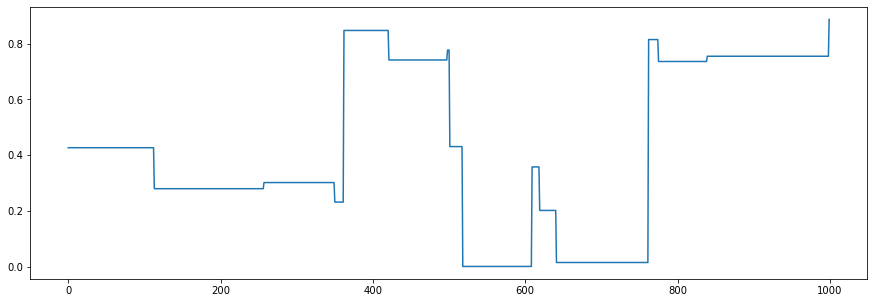

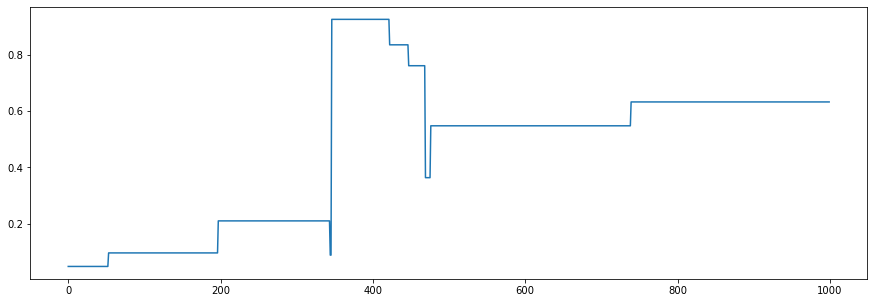

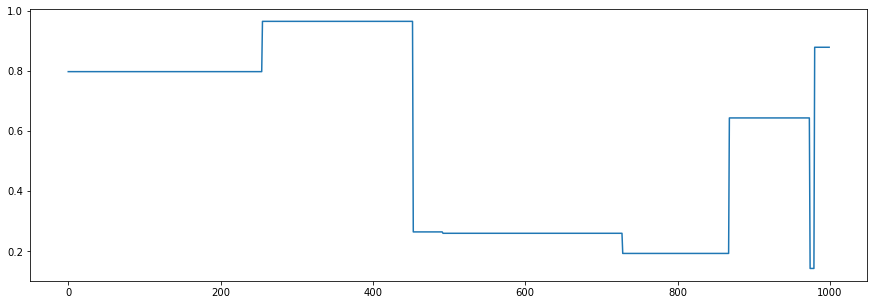

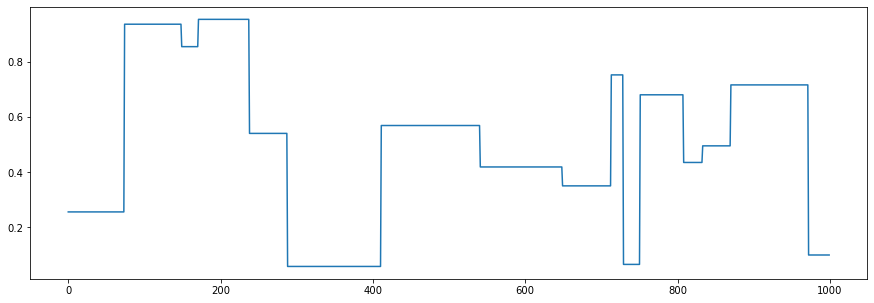

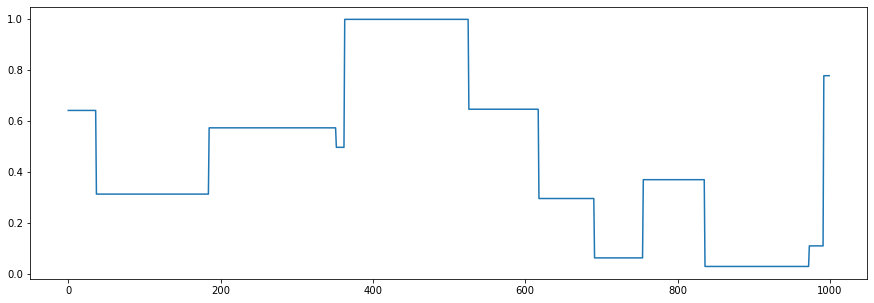

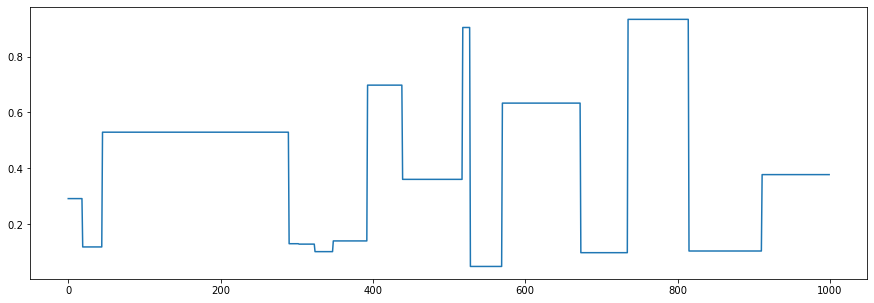

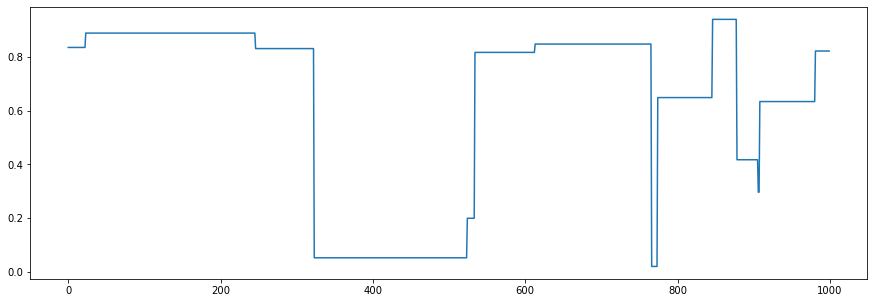

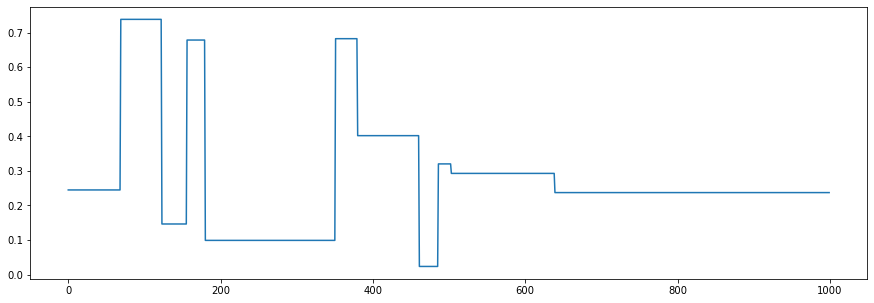

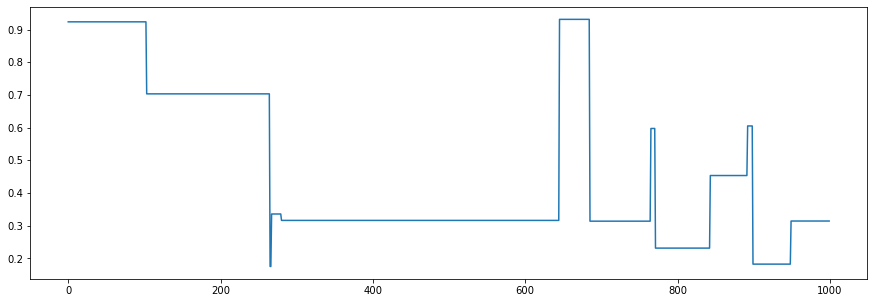

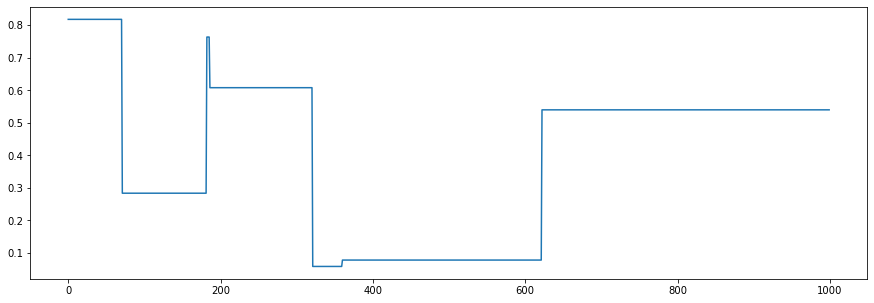

In [4]:
from jax.scipy.special import logit, expit

sigma = .01
def process(t, choices, states, rng_key):
    probs, _ = states
    
    rng_key, _rng_key = random.split(rng_key)
    x =  logit(probs) + np.sqrt(sigma) * random.normal(_rng_key, shape=(K,))
    
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    return outcomes[choices], [expit(x), np.zeros(K, dtype=np.int32)]

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(K, dtype=np.int32)]
    choices = np.arange(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [5]:
sequence = simulator(process, N=N)

for i in range(N):
    plt.subplots(figsize=(15, 5))
    plt.plot(sequence['probs'][:, i])

obs_drft = sequence['rewards']#[:, 0]
probs_drft = sequence['probs']#[:, 0]

log_like_drft = np.array([probs_drft[i]*o + (1-probs_drft[i])*(1-o) for i, o in enumerate(obs_drft.astype(np.int32))])
log_like_drft = np.log(log_like_drft)

print(obs_drft[2])

print(log_like_drft.sum(axis=0))

[False False  True  True False False  True False  True  True]
[-622.855   -169.04625 -218.66716 -359.1483  -383.57806 -595.67804
 -284.18558 -512.6615  -290.20514 -429.10062]


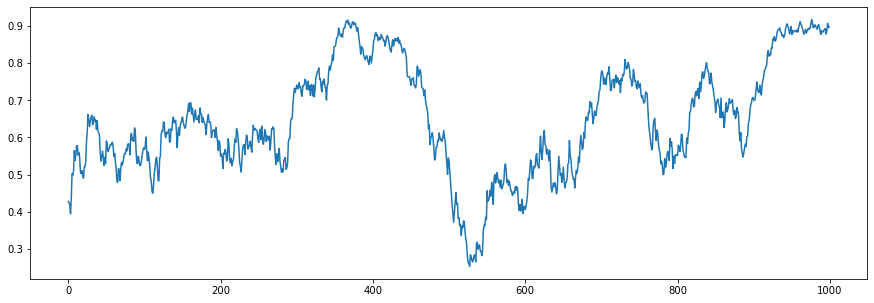

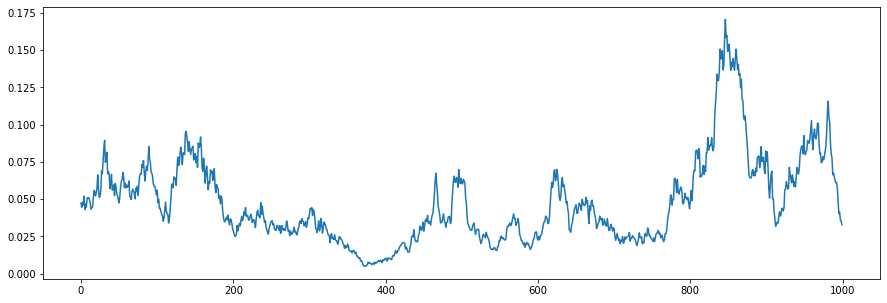

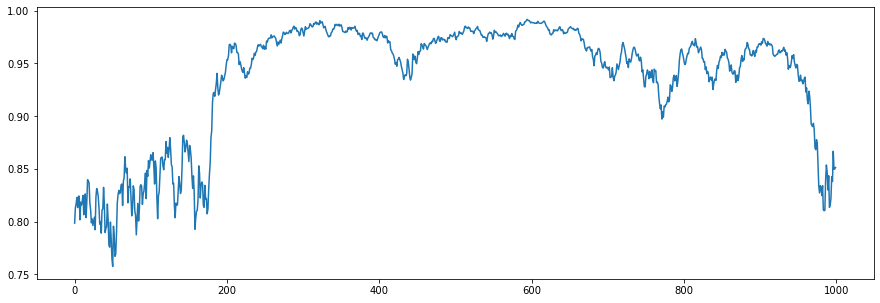

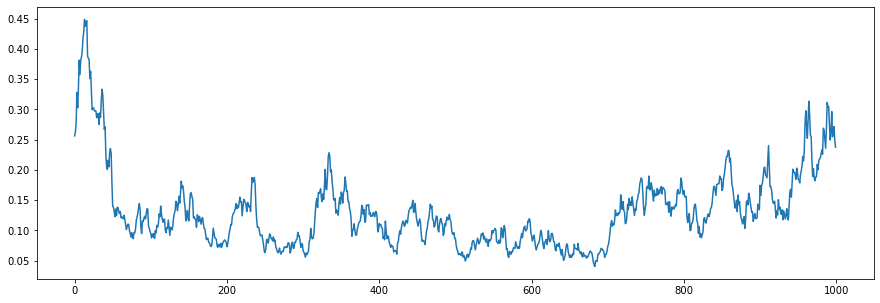

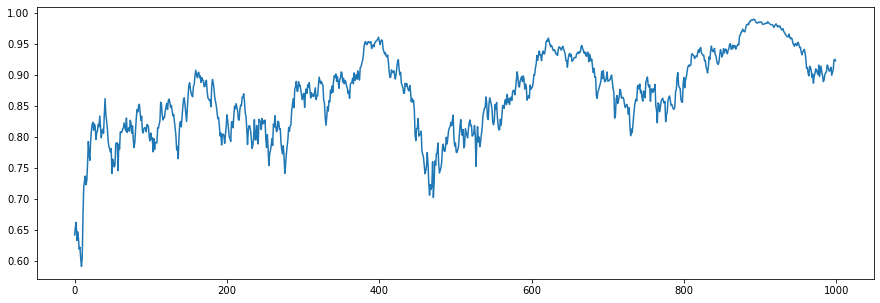

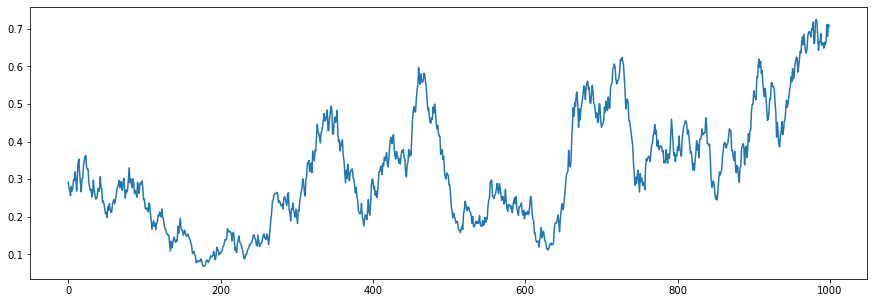

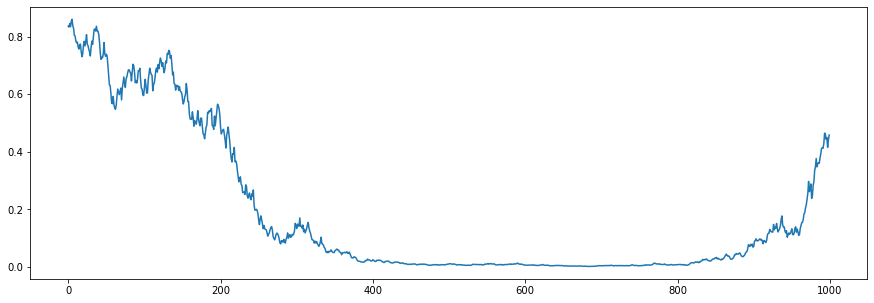

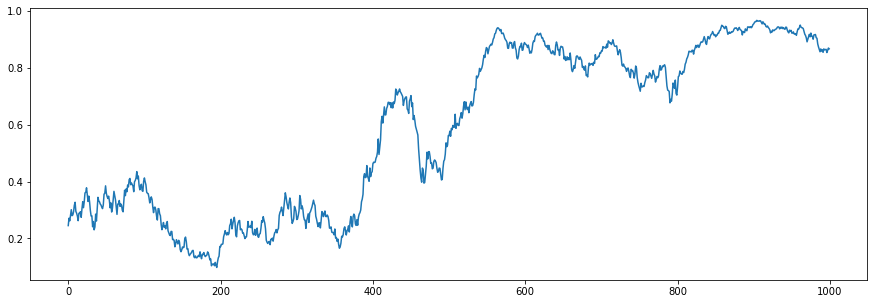

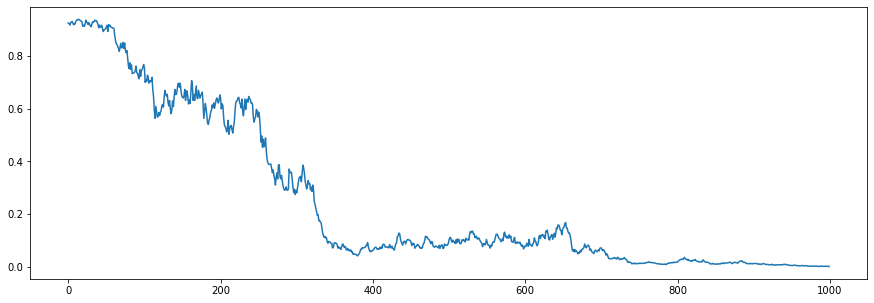

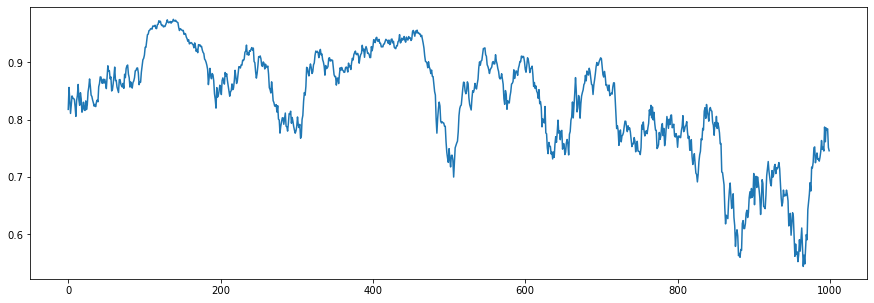

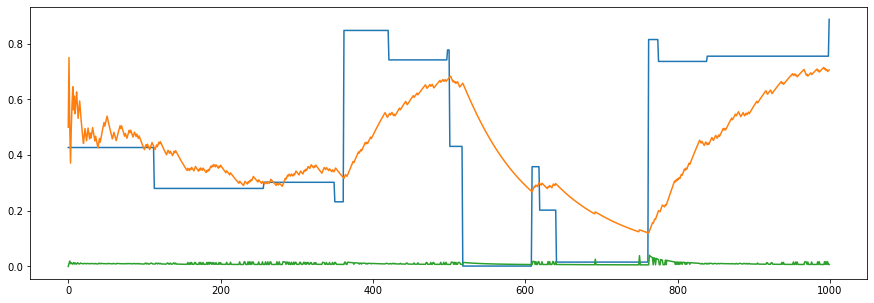

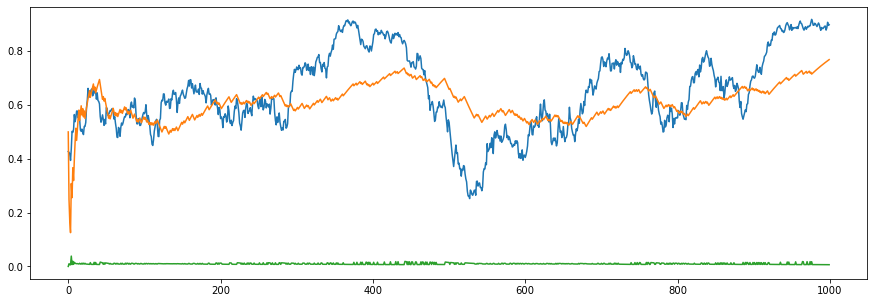

In [6]:
def learning(outcomes):
    a = [.5]
    b = [.5]
    
    m = [.5]
    e = [0.]
    for o in outcomes:
        pred = rho * (1 - e[-1])
        post = .5 * pred / (.5 * pred + m[-1]**o * (1-m[-1])**(1-o) * (1 - pred))
        a.append(a[-1] * ( 1 - post) + post * a[0] + o)
        b.append(b[-1] * (1 - post) + post * b[0] + (1 - o))
        m.append(a[-1]/(a[-1] + b[-1]))
        e.append(post)
        
    return m, e

F_swtch = []
F_drft = []
learning_names = []

log_likes = []

for i in range(N):

    m, e = learning(obs_swtch[:,i])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_swtch[:,i])
        plt.plot(m[:-1])
        plt.plot(e[:-1])
        plt.show()

    log_like = np.array([m[:-1][j]*o + (1-m[:-1][j])*(1-o) for j, o in enumerate(obs_swtch[:,i])])
    log_likes.append(np.log(log_like))
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("simple bayes")

log_likes = []

for i in range(N):

    m, e = learning(obs_drft[:,i])
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_drft[:,i])
        plt.plot(m[:-1])
        plt.plot(e[:-1])
        plt.show()
    
    log_like = np.array([m[:-1][j]*o + (1-m[:-1][j])*(1-o) for j, o in enumerate(obs_drft[:,i])])
    log_likes.append(np.log(log_like))
    
F_drft.append(np.array(log_likes).T)

Although it seems like the above variational algorithm does a fairly good job, it turns out that it is very slow in adjusting to changes as it underestimates uncertainty. One can see this using the following alghoritm that approximate likelihood with a set of descrete points, and implements an exact filtering algorithm.

Lets assume that reward probability can have only discrete value, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate different possible values with descrete hidden states $k_t$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(k_t|k_{t-1}, j_{t-1}=0) = I_D$$

that is, states do not change in the absence of a change point, and

$$ p(k_t|k_{t-1}, j_{t-1}=1) = \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(k_t, j_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t|o_{1:t-1})$$

where 

$$ p(o_t|k_t=k) = p_k^{o_t}(1-p_k)^{1-o_t}$$

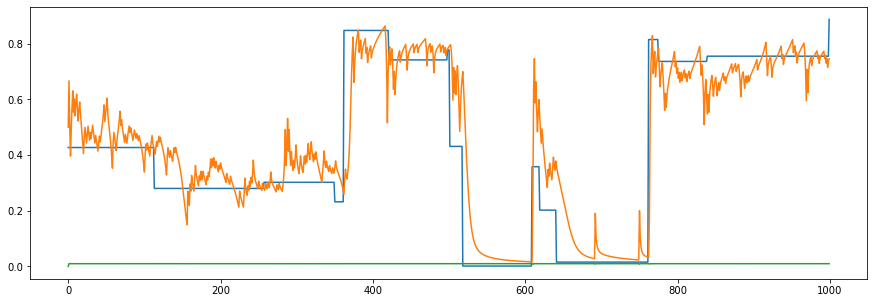

In [7]:
D = 100
p_jj = np.exp(log_p_jj)
p_jss = np.stack([np.eye(D), (np.ones((D,D)) - np.eye(D))/(D-1)], 0)

def learning(outcomes, D=10):
    likelihoods = np.arange(1/(2*D), 1., 1/D)[:, None]
    
    def scan_fn(probs, o):
        pred = np.einsum('ijk,il,ji->kl', p_jss, p_jj, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = np.sum(probs * likelihoods)
        e = probs.sum(-2)[-1]
        
        q = post/post.sum()
        return q, (m, e, q)

    probs = np.ones((D, 1))/D * np.array([1., 0])
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[-1]

log_likes = []

for i in range(N):
    m, e, post = learning(obs_swtch[:,i], D=D)

    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_swtch[:,i])
        plt.plot(m)
        plt.plot(e)
        plt.show()
    
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_swtch[:,i])])
    log_likes.append(np.log(log_like))
F_swtch.append(np.array(log_likes).T)
learning_names.append("discrete states")

log_likes = []

for i in range(N):
    m, e, post = learning(obs_drft[:,i], D=D)

    
    if i == 0:
        plt.subplots(figsize=(15, 5))
        plt.plot(probs_drft[:,i])
        plt.plot(m)
        plt.plot(e)
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_drft[:,i])])
    log_likes.append(np.log(log_like))
F_drft.append(np.array(log_likes).T)

Interestingly, although we consider only switching dynamics in the generative model, we get a fairly good estimates of the underlying probabilities in the drifting environment.

Above we have assumed that the agent already knows the change point probability, however in general this will be a hidden quantity for the agent. Here we will add another to the hierarchical HMM which corresponds to the  the change point probability also. Similar to likelihoods we can discretise the change point probability $\rho$ and assume that 

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

We will associate different possible values with descrete hidden states $r_t$, and express the change point transition matrix as 

\begin{equation}
    p(j_{t}=j|j_{t-1}, r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1,l} = 1  \\
        \rho_r^{j}(1-\rho_r)^{1-j} & \textrm{for } j_{t-1,l} = 0
    \end{array}
    \right.
\end{equation}

and the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with pr. } 1 - \kappa  \\
        \delta_{q, r + 1} & \textrm{with pr. } \kappa/2 \\
        \delta_{q, r - 1} & \textrm{with pr. } \kappa/2
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(k_t, j_t, r_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t, r_t|o_{1:t-1})$$

where we will assume a priory a bias toward small change probabilities, hence 

$$ p(r_0 = r) \propto e^{-\lambda r} $$

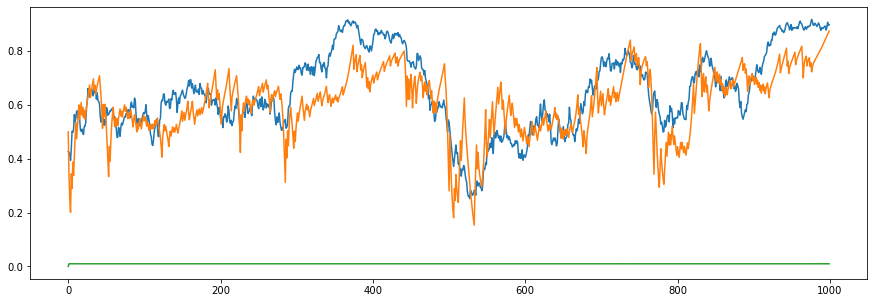

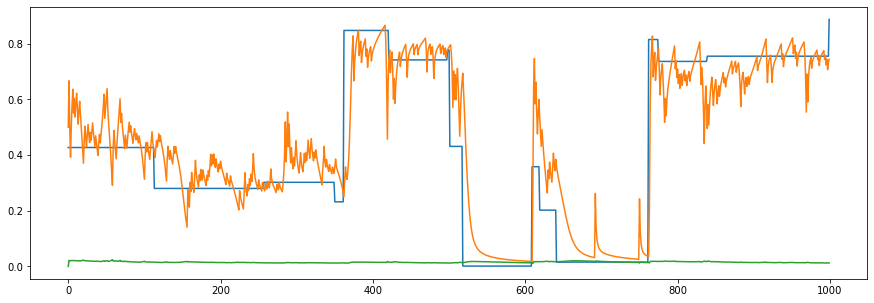

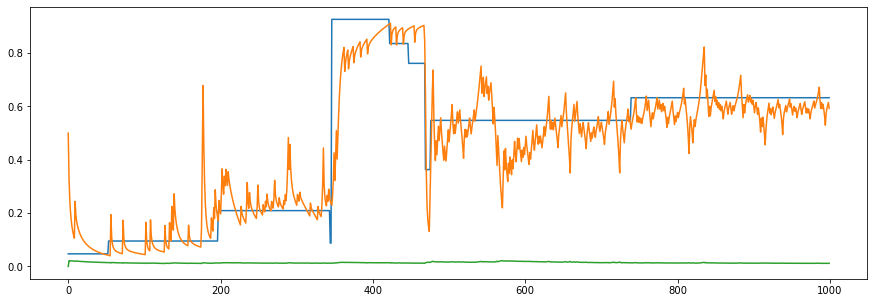

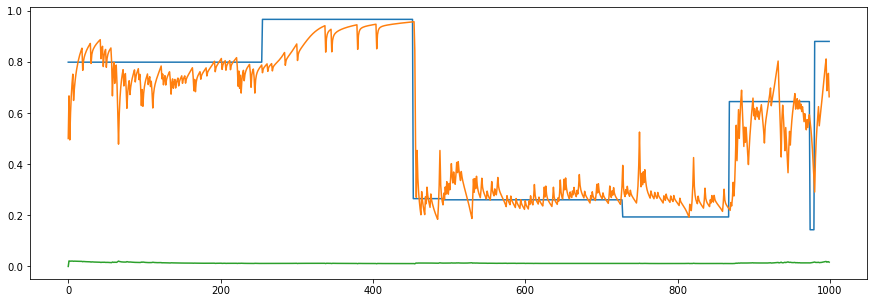

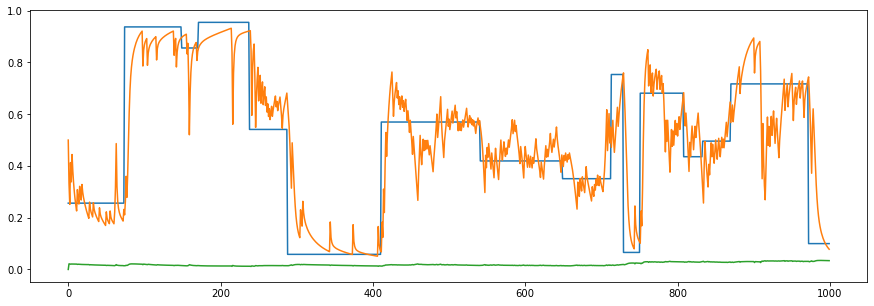

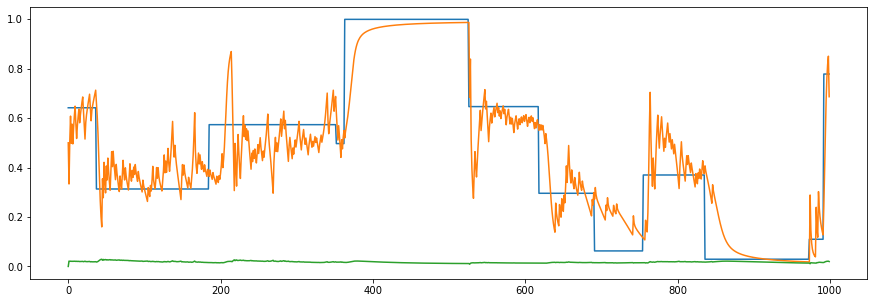

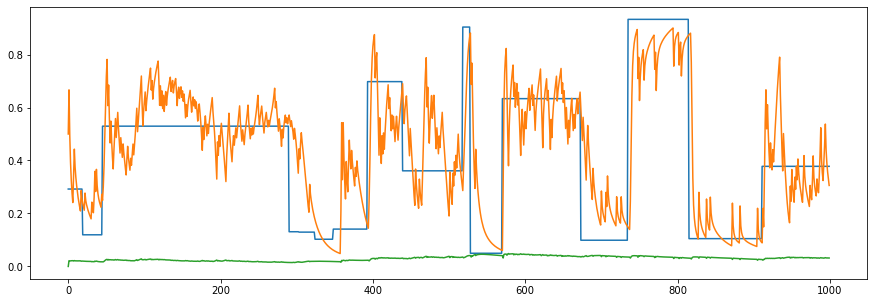

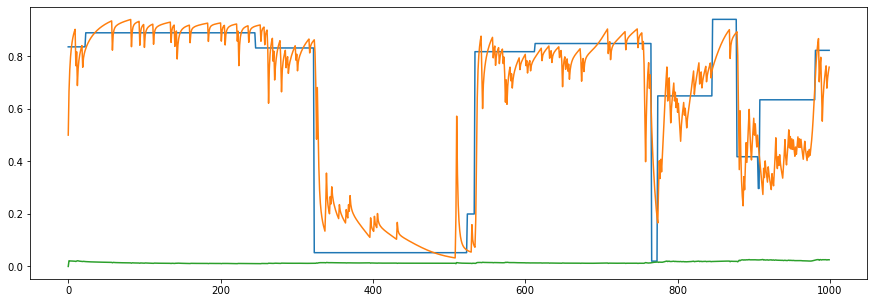

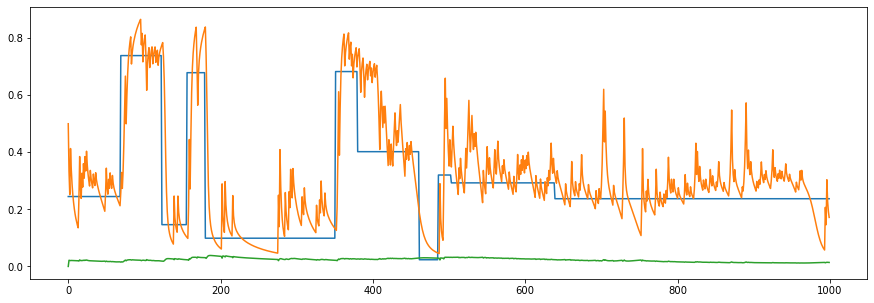

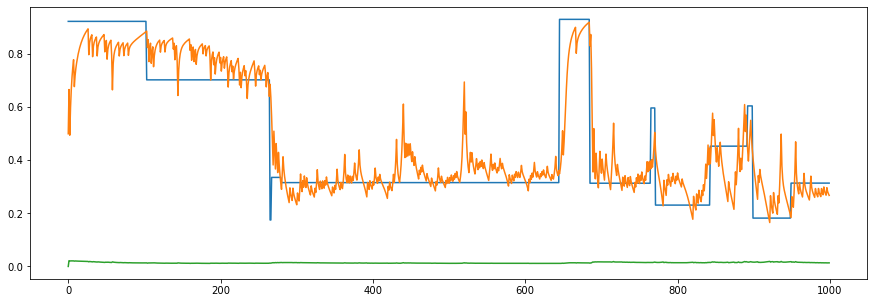

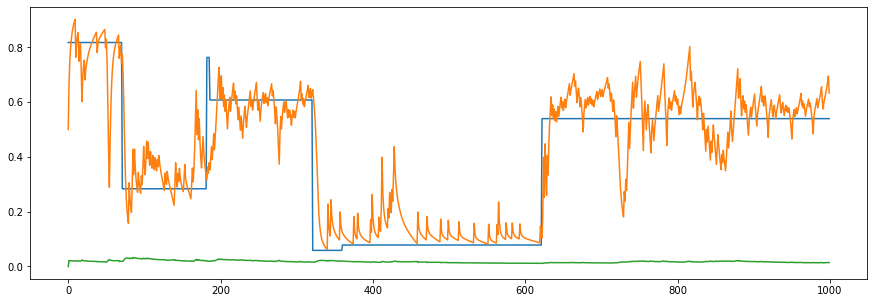

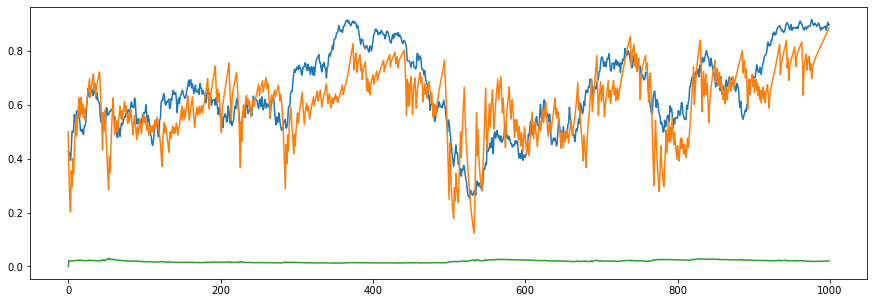

In [8]:
def learning(outcomes, D=10, M=10):
    
    p_jss = np.stack([np.eye(D), (np.ones((D,D)) - np.eye(D))/(D-1)], 0)
    
    likelihoods = np.arange(1/(2*D), 1., 1/D)[:, None, None]
    
    rho = np.arange(1/(2*M), 1, 1/M)
    stay = np.stack([1 - rho, rho], -1)
    change = np.array([1., 0.])[None].repeat(M, -2)
    p_rjj = np.stack([stay, change], -2)
    
    kappa = 1e-3
    p_rr = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
    p_rr = ops.index_update(p_rr, ops.index[[0, -1], [1, -2]], kappa)
    
    def scan_fn(probs, o):
        pred = np.einsum('jsk,rjl,rq,sjr->klq', p_jss, p_rjj, p_rr, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = np.sum(probs * likelihoods)
        e = probs[:, -1].sum()
        r = np.sum(probs * rho)
        
        q = post/post.sum()
        return q, (m, e, r, q)
    
    r0 = np.exp(- 1 * np.arange(M)) #np.eye(M)[0]
    probs = np.ones((D, 1, 1))/D * np.array([1., 0])[:, None] * r0/r0.sum()
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[2], sequence[3]

D = 100
M = 50

log_likes = []

for i in range(N):
    m, e, r1, post = learning(obs_swtch[:,i], D=D, M=M)
    
    #if i == 0:
    plt.subplots(figsize=(15, 5))
    plt.plot(probs_swtch[:,i])
    plt.plot(m)
    plt.plot(e)
        
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_swtch[:,i])])
    log_likes.append(np.log(log_like))
    
F_swtch.append(np.array(log_likes).T)
learning_names.append("discrete states with volatility")

log_likes = []

for i in range(N):

    m, e, r2, post = learning(obs_drft[:,i], D=D, M=M)
    
    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.plot(probs_drft[:,i])
        plt.plot(m)
        plt.plot(e)
        plt.show()
        
    log_like = np.array([m[j]*o + (1-m[j])*(1-o) for j, o in enumerate(obs_drft[:,i])])
    log_likes.append(np.log(log_like))
F_drft.append(np.array(log_likes).T)

#plt.subplots(figsize=(15, 5))
#plt.plot(r1)
#plt.plot(r2)

Well, so far so good. We can implement the discretised generative model for various dynamic MABs or try to figure out a equally good varaitional inference algo.

Instead of discretizing the reward probability $p$, we can try to learn it using a Beta distribution as a conjugate prior
\begin{equation}
p(o_t,\theta|o_{1:t-1}) = p(o_t|\theta_t)p(\theta_t|o_{1:t-1})
\end{equation}
where the likelihood is defines as a Bernoulli distribution
\begin{equation}
p(o_t|\theta) = \theta_t^{1-o_t}\left( 1 - \theta_t \right)^{o_t}
\end{equation}
and the prior as Beta distribution
\begin{equation}
p(\theta|o_{1:t-1}) = \frac{1}{B(\alpha^\prime_t, \beta^\prime_t)} \theta^{\beta^\prime_t-  1} \left(1 - \theta \right)^{\alpha^\prime_t-1}.
\end{equation}

Hence, the expected reward probability, $p(o_t=1|o_{1:t-1})$, corresponds to 

$$\frac{\alpha^\prime_t}{\alpha^\prime_t+\beta^\prime_t}$$

As the Beta distribution is the conjugate prior of the Bernoulli distribution, thus the posterior will also correspond to a Beta distribution 

\begin{equation}
p(\theta_t|o_{1:t}) = \frac{1}{B(\alpha_t, \beta_t)}\left(1 - \theta_t\right)^{\alpha_t-1}\theta_t^{\beta_t-1}
\end{equation}

hence yielding the followin iterative update equations

\begin{equation}
\begin{split}
    \alpha_t &= \alpha^\prime_t + o_t \\
    \beta_t &= \beta^\prime_t + 1 - o_t
\end{split}
\end{equation}

To introduce forgeting of old observations (e.g. because recently environment changed) we can express the prior at $t$ as a functional of the posterior at time $t-1$, such that

\begin{equation}
p(\theta_t|o_{1:t-1}) = \int d\theta_{t-1} p(\theta_t|\theta_{t-1}, \kappa) p(\theta_{t-1}|o_{1:t-1}) = p(\theta_{t}|o_{1:t-1}, \kappa) \propto Beta(\alpha_{t-1}, \beta_{t-1})^\kappa Beta(\alpha_0, \beta_0)^{1-\kappa}
\end{equation}
hence 

\begin{equation}
\begin{split}
    \alpha^\prime_t &= \kappa \alpha_{t-1} + (1 - \kappa)\alpha_0 \\
    \beta^\prime_t &= \kappa \beta_{t-1} + (1 - \kappa)\beta_0
\end{split}
\end{equation}

If we set $m_t = \frac{\alpha_t}{\nu_t}$ and $\nu_t = \alpha_t + \beta_t$ we can express the update equations 
as

\begin{equation}
\begin{split}
    m_t &= m_{t-1} + \frac{1}{\nu_{t}} \left(o_t - m_{t-1} \right) + \frac{2 \cdot( 1 - \kappa)}{\nu_{t}} \left(\frac{1}{2} - m_{t-1} \right) \\
    \nu_t & = \kappa \nu_{t-1} + 2 * (1 - \kappa) + 1
\end{split}
\end{equation}

Notice that in the above equations $\frac{1}{\nu_t}$ corresponds to the learning rate. In the limit of large number of trials $t \gg 1$ we get that

$$ \nu^* = \kappa \nu^* + 1 - \kappa + 1 \rightarrow \nu^* = 1 + \frac{1}{1-\kappa}$$

Which tells us that after many observation learning rate converges to $(1 - \kappa)/(2 - \kappa)$.

## Adaptive learning rate

As $\kappa$ defines the long-term limit of the learning rate, in volatile environments that require adaptive learning rates, we can assume that $\kappa$ also changes over time, hence $\kappa \rightarrow \kappa_t$. Following the proposal of Moens et al. (eq. (10)) we will use the following hierarchical filter as a generative model 

$$ p(\theta_t, \kappa_t, \omega| o_{1:t}) \propto p(o_t|\theta_t) \bar{p}(\theta_t|\kappa_t)\bar{p}(\kappa_t| \omega) \bar{p}(\omega)$$

where 

\begin{equation}
\begin{split}
\bar{p}(\theta_t| \kappa_t) &\propto Beta(\alpha_{t-1}, \beta_{t-1})^{\kappa_t} Beta(\alpha_0, \beta_0)^{1-\kappa_t} \\
\bar{p}(\kappa_t| \omega) & \propto Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1})^{\omega} Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)^{1-\omega}\\
\bar{p}(\omega) & = Beta(\alpha^{\omega}_{t-1}, \beta^{\omega}_{t-1})
\end{split}
\end{equation}

Assuming the mean-field approximation for the posterior, thus

$$ p(\theta_t, \kappa_t, \omega| o_{1:t}) \approx Q(\theta_t)Q(\kappa_t)Q(\omega)$$

we obtain the following update equations

\begin{equation}
\begin{split}
Q(\theta_t) &\propto exp\left\{ \hat{\kappa}_t \ln Beta(\alpha_{t-1}, \beta_{t-1}) + (1-\hat{\kappa}_t)  Beta(\alpha_0, \beta_0) \right\}  \\
Q(\kappa_t) & \propto exp \left\{ \hat{\omega} \ln Beta(\alpha^{\kappa}_{t-1}, \beta^{\kappa}_{t-1}) + (1-\hat{\omega}) \ln Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0) - \ln Z(\kappa_t) + \kappa_t E_{Q(\theta_t)}\left[\ln \frac{Beta(\alpha_{t-1}, \beta_{t-1})}{Beta(\alpha_0, \beta_0)}\right] \right\}\\
Q(\omega) &\propto \bar{p}(\omega) exp \left\{- \ln Z(\omega) + \omega E_{Q(\kappa_t)}\left[\ln \frac{Beta(\alpha^\kappa_{t-1}, \beta^{\kappa}_{t-1})}{Beta(\alpha^{\kappa}_0, \beta^{\kappa}_0)}\right] \right\}
\end{split}
\end{equation}

Assuming the beta distribution for the approximate posterior over $\theta_t, \kappa_t$ and $\omega$ requires a non-conjugate variational inference for defining parameter updates for $\alpha^{\kappa}_t, \beta^{\kappa}_t$ and $\alpha^{\omega}_t, \beta_t^{\omega}$. 

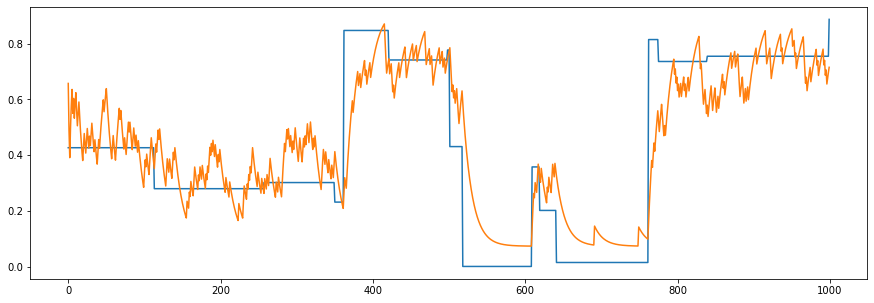

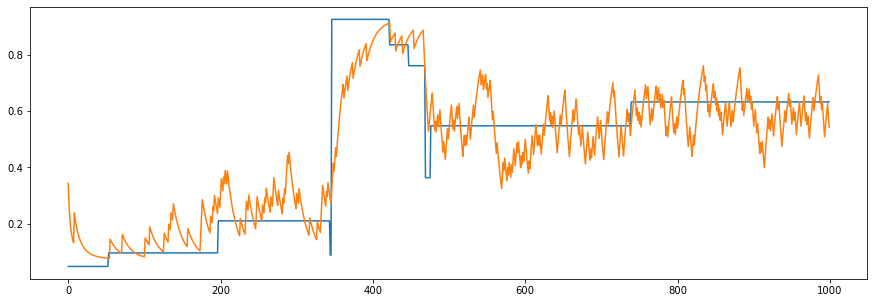

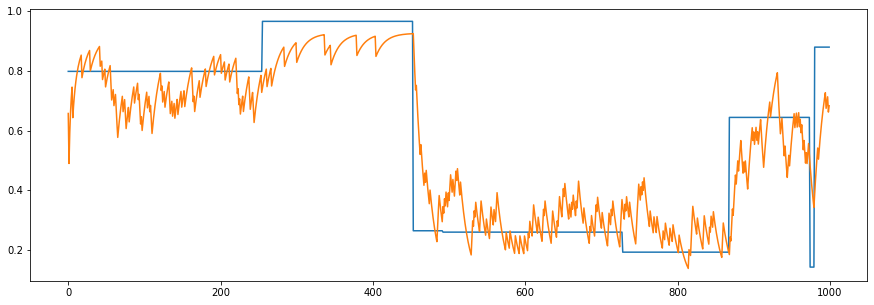

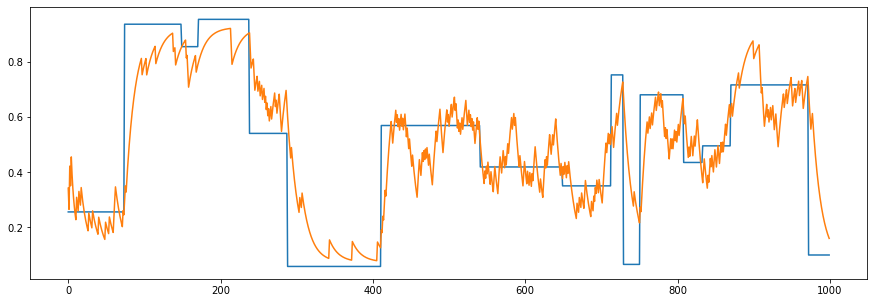

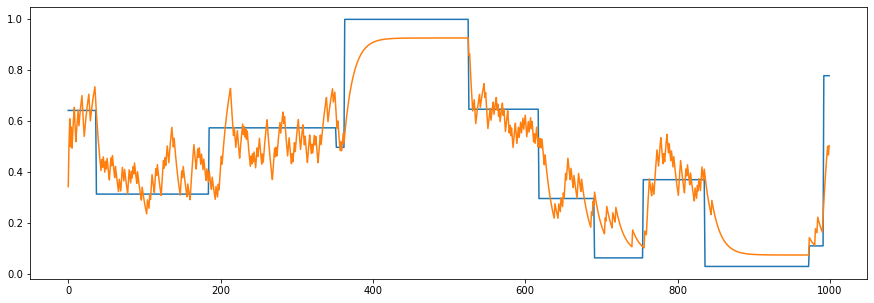

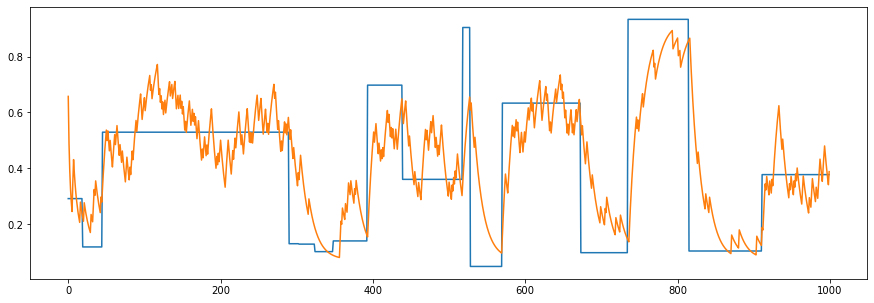

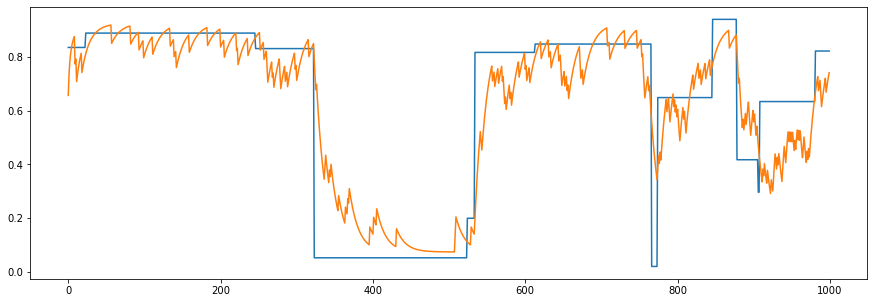

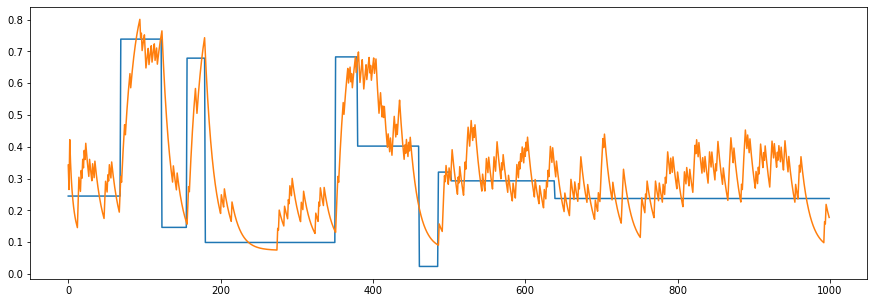

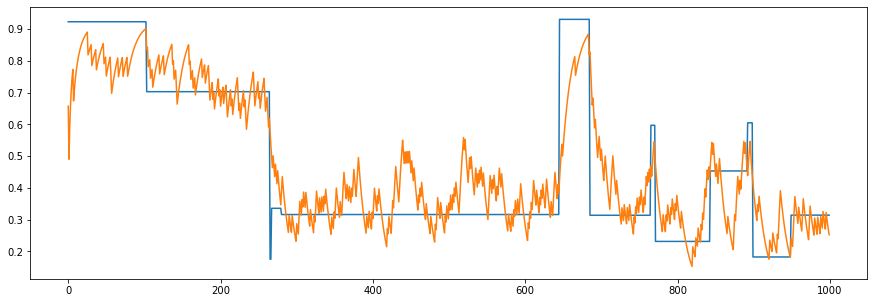

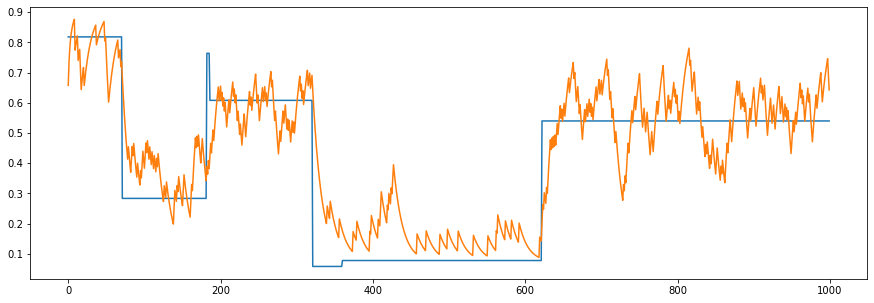

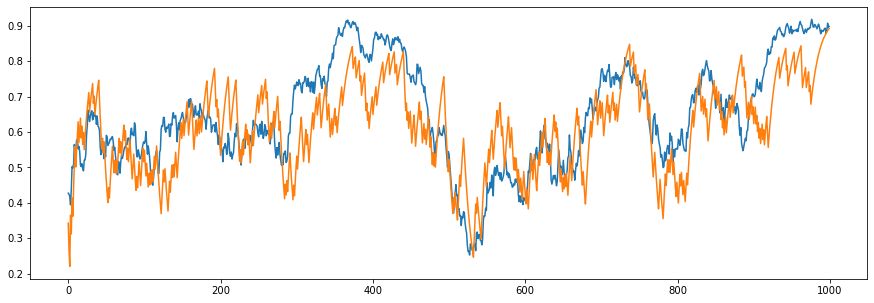

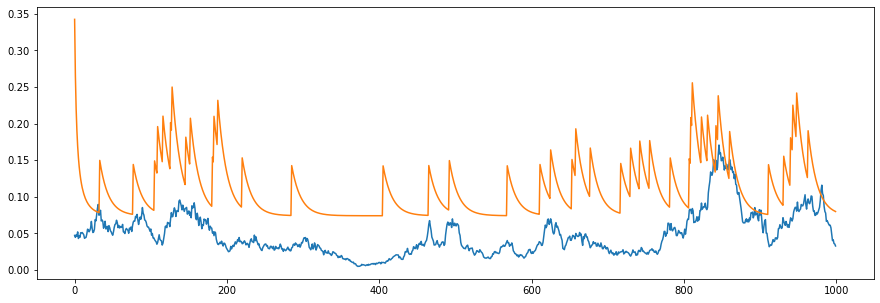

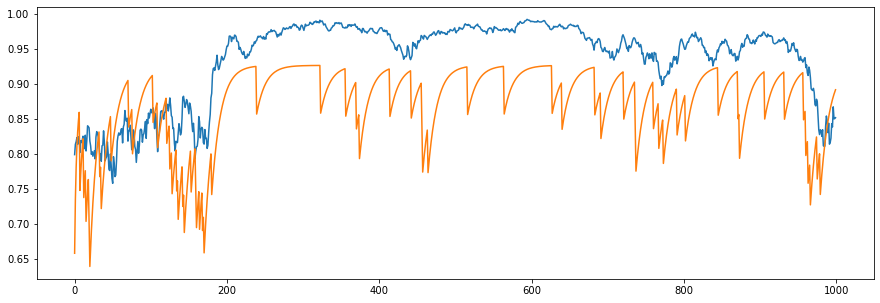

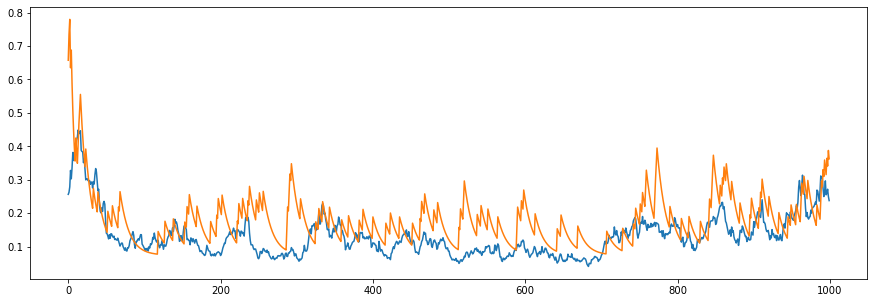

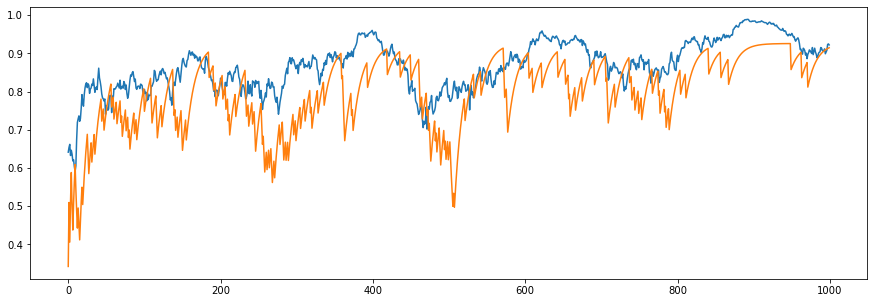

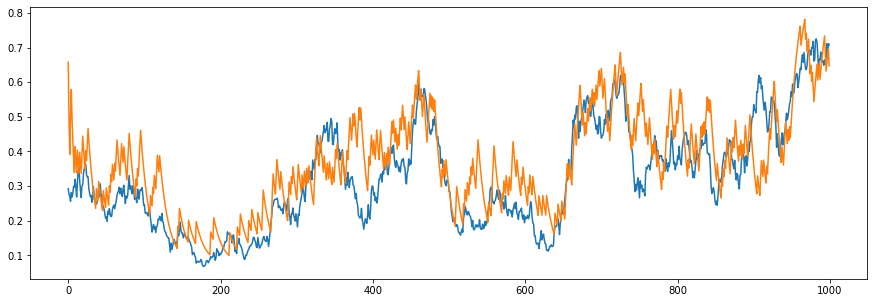

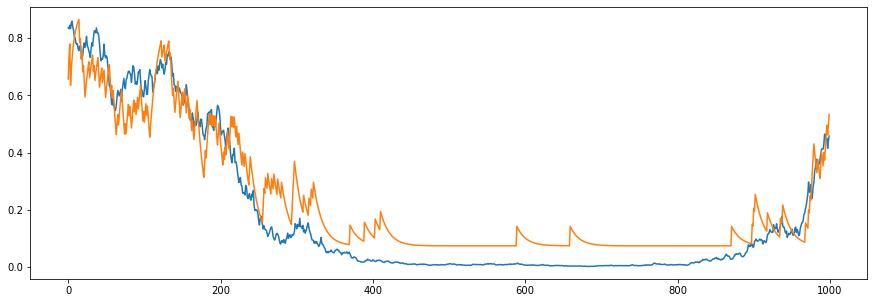

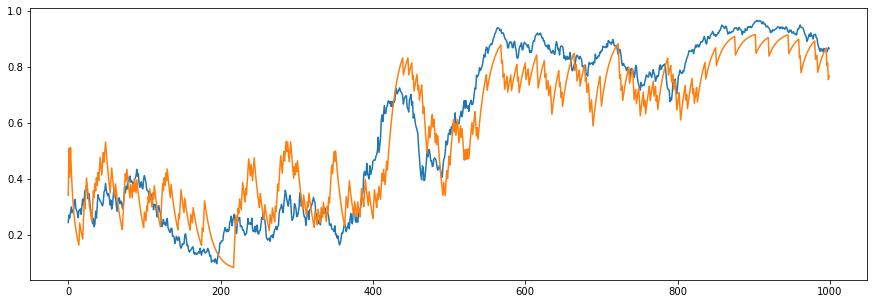

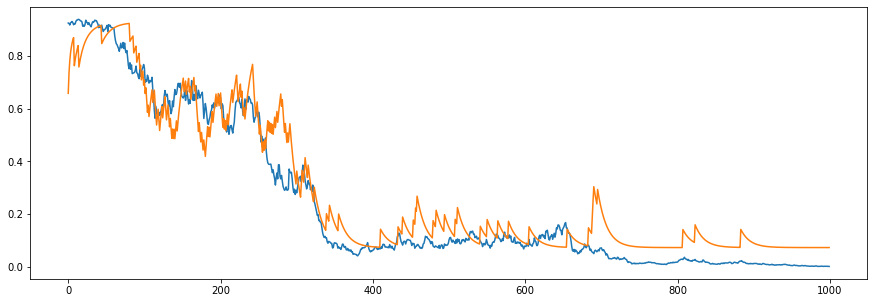

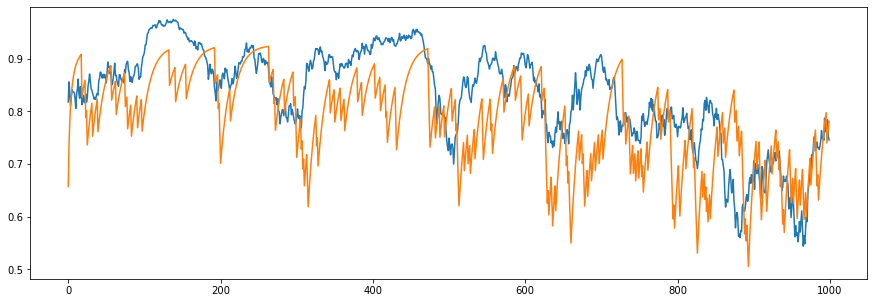

In [9]:
kappa = 0.92

def learning(outcomes):
    
    
    def scan_fn(carry, o):
        
        post_p, post_alpha = carry
        N = post_p.shape[0]
        obs = o.astype(np.float32)
        alpha_0 = 1-obs + kappa * post_alpha[:,0] + 1 - kappa
        alpha_1 = obs + kappa * post_alpha[:,1] + 1 - kappa
        q_alpha = np.array([alpha_0, alpha_1]).T
        q_p = kappa * q_alpha + 1 - kappa
        q_p /= q_p.sum(axis=-1)[:,np.newaxis]
        
        return (q_p, q_alpha), {'prob': q_p, 'alpha': q_alpha}

    q_p_init = np.array(N*[[0.5,0.5]], dtype=np.float32)
    q_alpha_init = np.array(N*[[1, 1]], dtype=np.float32)
    carry = (q_p_init, q_alpha_init)
    _, sequence = lax.scan(scan_fn, carry, outcomes)
        
    return sequence

sequence = learning(obs_swtch)
q_p = sequence['prob']
q_alpha = sequence['alpha']

for i in range(N):
    plt.subplots(figsize=(15, 5))
    plt.plot(probs_swtch[:,i])
    plt.plot(q_p[:,i,1])

#plt.subplots(figsize=(15, 5))
#plt.plot(q_alpha[:,1])
#plt.plot(q_alpha[:,0])

log_like = np.array([q_p[i,:,1]*o + (1-q_p[i,:,1])*(1-o) for i, o in enumerate(obs_swtch)])
log_like = np.log(log_like)
F_swtch.append(log_like)
learning_names.append("parametric fix kappa")

sequence = learning(obs_drft)
q_p = sequence['prob']
q_alpha = sequence['alpha']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_drft[:,i])
    plt.plot(q_p[:,i,1])
    plt.show()

log_like = np.array([q_p[i,:,1]*o + (1-q_p[i,:,1])*(1-o) for i, o in enumerate(obs_drft)])
log_like = np.log(log_like)
F_drft.append(log_like)

Update equations according to Lu et al. 2019, using the same notation as in the article.

The authors assume Bernoulli bandits, where the reward probability is estimated as
\begin{equation}
\hat{Y} = \frac{1}{w_{t}} \sum_{i=1}^{t} (\prod_{p=1}^{t-1} \kappa_{p}) Y_{i}
\end{equation}
depending on an adaptive discount/forgetting factor $\kappa_t$ and observations $Y_t$. This leads to the update equations
\begin{align}
\hat{Y}_{t} &= \frac{m_t}{w_t} \\
m_t &= \kappa_{t-1} m_{t-1} + Y_t \\
w_t &= \kappa_{t-1} w_{t-1} + 1
\end{align}
and $\kappa_t$ is computed via a single gradient descent step
\begin{align}
\kappa_t &= \kappa_{t-1} - \eta \Delta (L_{t}, \kappa_{1:t-2}) \\
L_{t} &= (\hat{Y}_{t-1}-Y_t)^2
\end{align}
where $L_t$ is a cost function, which could potentially have a different form.The gradient descent step is then
\begin{align}
\Delta (L_{t}, \kappa_{1:t-2}) &= 2(\hat{Y}_{t-1}-Y_t) (\frac{\dot{m}_{t-1} - \dot{w}_{t-1}\hat{Y}_{t-1}}{w_{t-1}}) \\
\dot{m}_{t} &= \kappa_{t-1}\dot{m}_{t-1} + m_{t-1} \\
\dot{w}_{t} &= \kappa_{t-1}\dot{w}_{t-1} + w_{t-1}
\end{align}

In terms of the notation above, $Y_t=o_t$, $m_t=\alpha_t$, $w_t=v_t$, and $\hat{Y}_t=m_t$. 

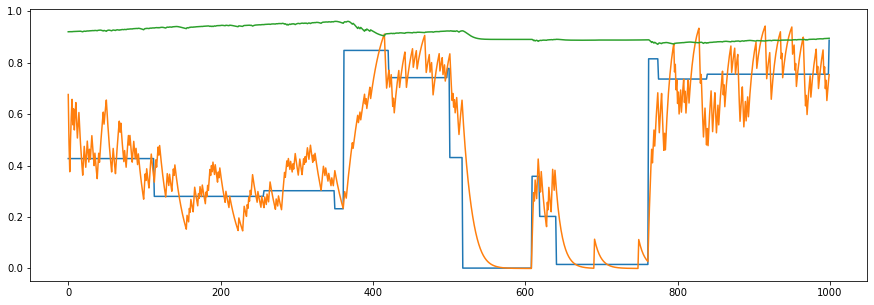

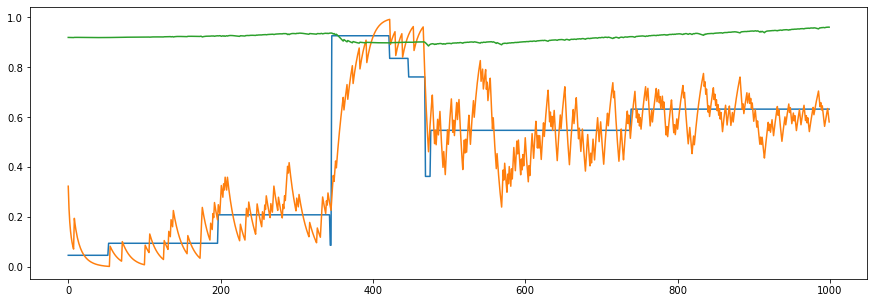

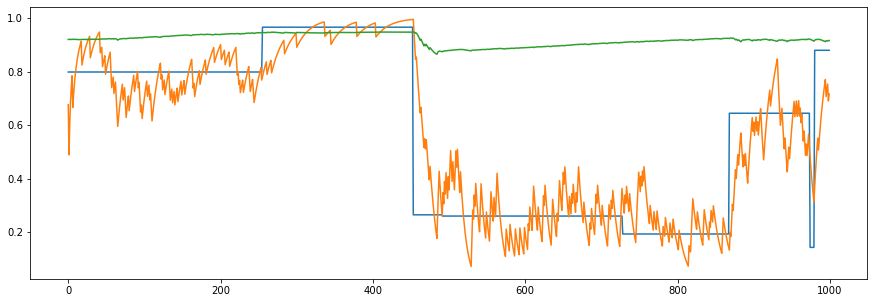

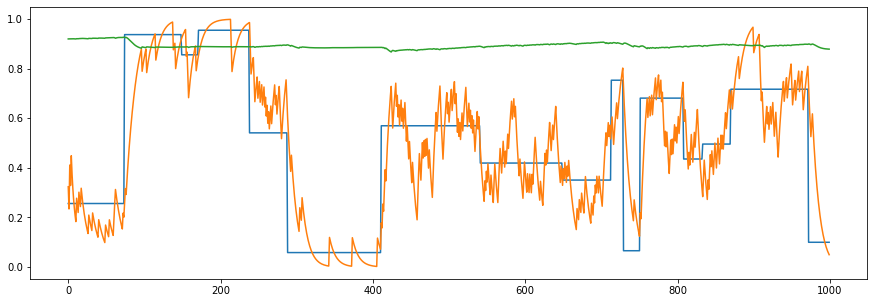

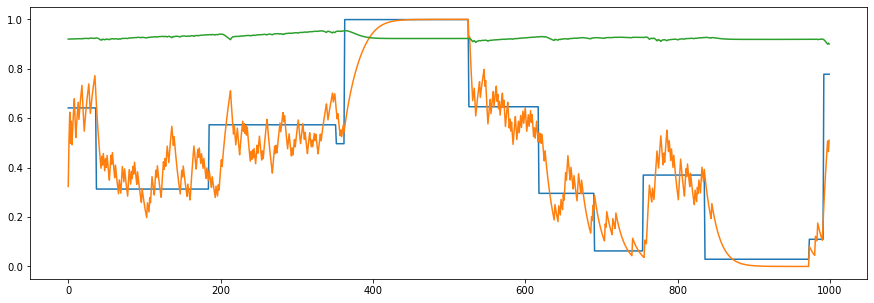

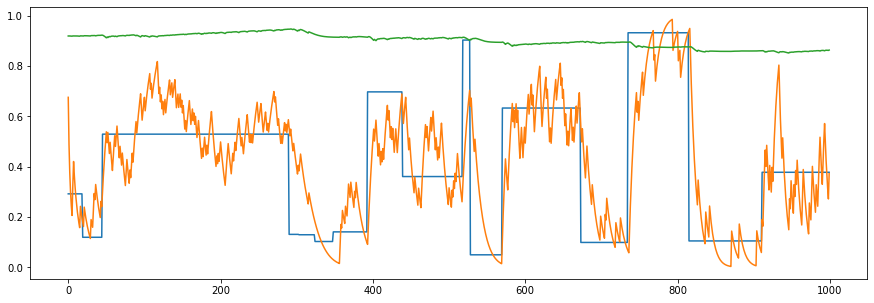

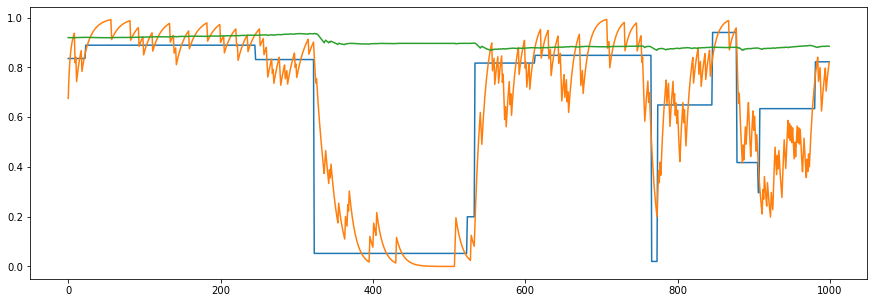

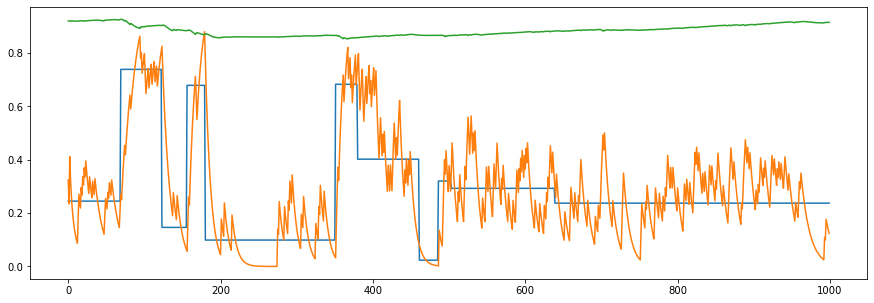

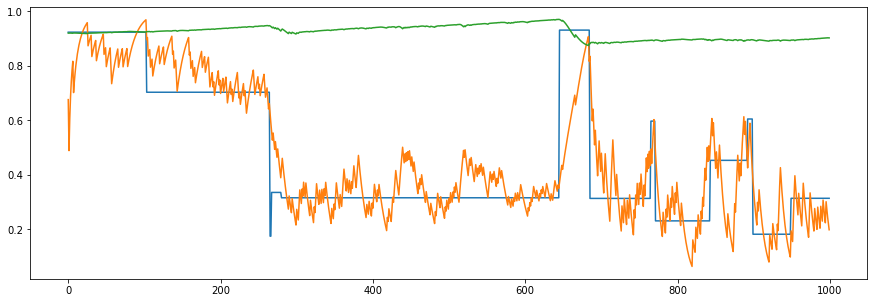

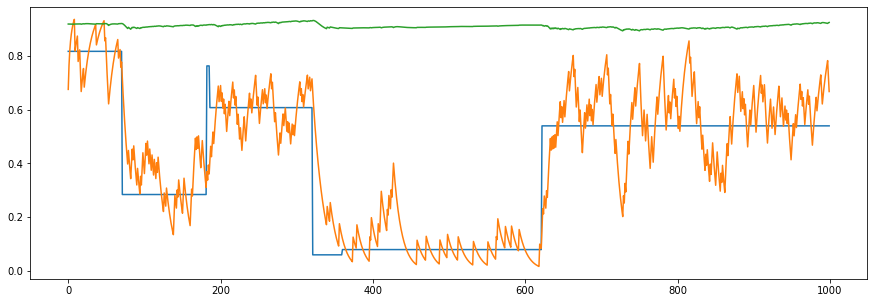

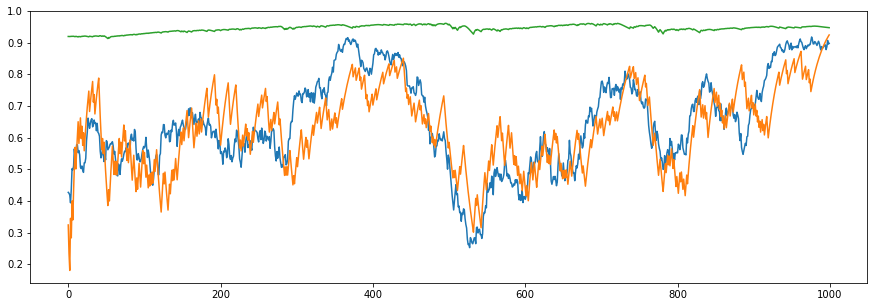

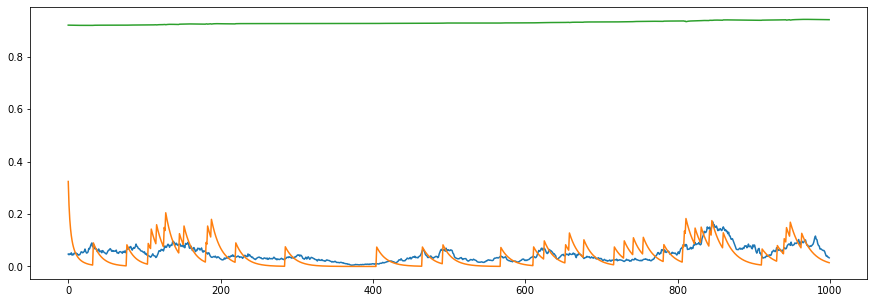

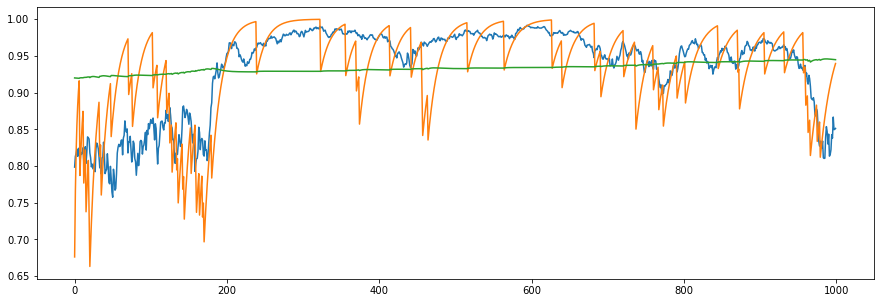

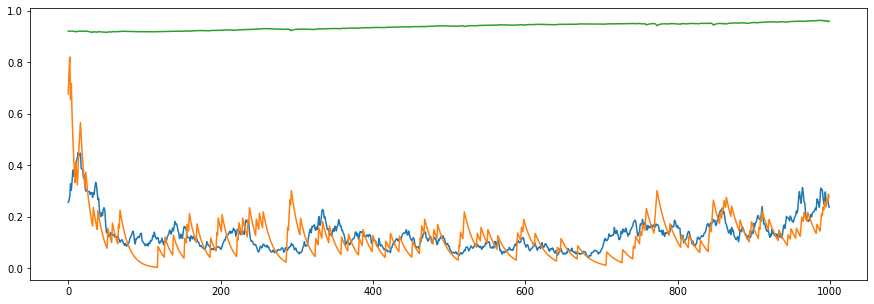

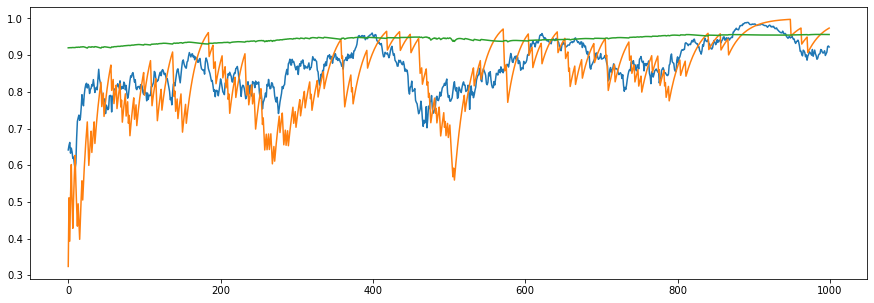

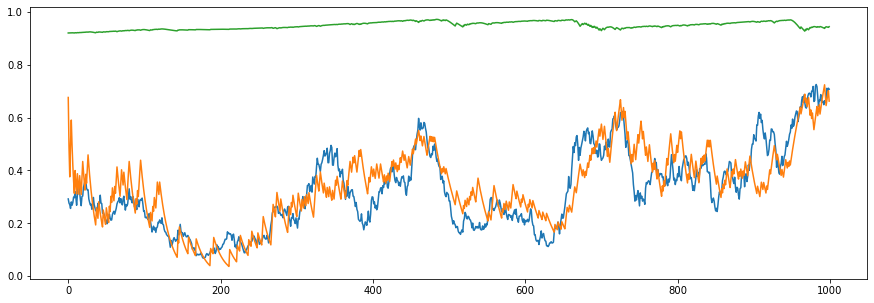

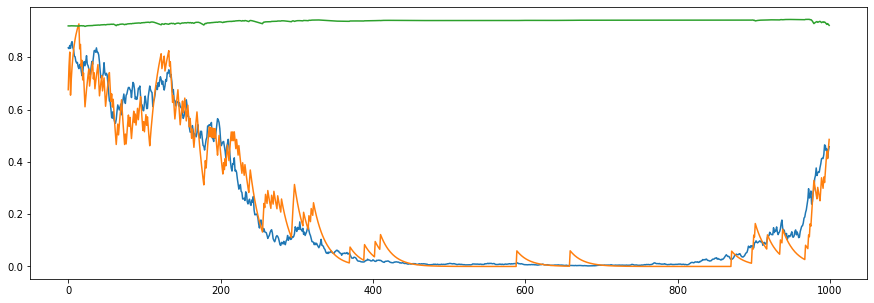

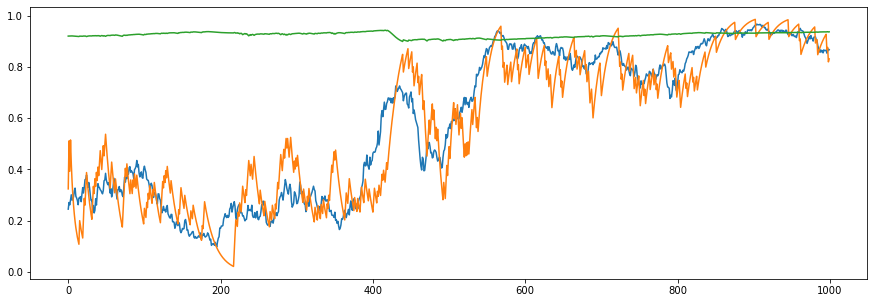

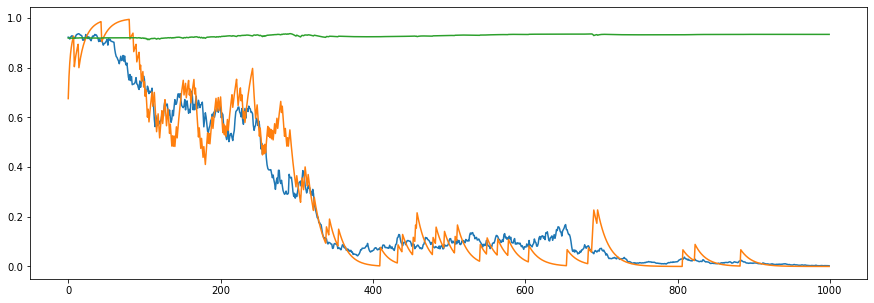

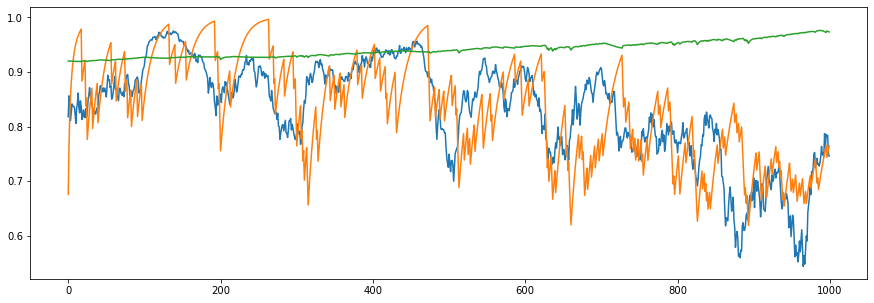

In [10]:
eta = 0.001

def learning(outcomes):
    
    
    def scan_fn(carry, o):
        post_p, post_alpha, kappa, m_dot, w_dot = carry
        
        obs = o.astype(np.int16)
        
        q_m_dot = kappa * m_dot + post_alpha[:,1]
        q_w_dot = kappa * w_dot + post_alpha.sum(axis=1)
        
        d_kappa = 2*(post_p[:,1]-o) * (m_dot - w_dot*post_p[:,1]) / post_alpha.sum(axis=1)
        q_kappa = kappa - eta * d_kappa
        
        alpha_0 = (1-obs) + kappa * post_alpha[:,0]
        alpha_1 = obs + kappa * post_alpha[:,1]
        
        q_alpha = np.array([alpha_0, alpha_1]).T
        
        q_p = q_alpha
        q_p /= q_p.sum(axis=1)[:,np.newaxis]
        
        return (q_p, q_alpha, q_kappa, q_m_dot, q_w_dot), {'prob': q_p, 'alpha': q_alpha, 'kappa': q_kappa}

    q_p_init = np.array(N*[[0.5,0.5]], dtype=np.float32)
    q_alpha_init = np.array(N*[[1, 1]], dtype=np.float32)
    kappa_init = np.array(N*[0.92])
    m_dot_init = np.array(N*[0.0])
    w_dot_init = np.array(N*[0.0])
    carry = (q_p_init, q_alpha_init, kappa_init, m_dot_init, w_dot_init)
    _, sequence = lax.scan(scan_fn, carry, outcomes)
        
    return sequence

sequence = learning(obs_swtch)
q_p = sequence['prob']
q_alpha = sequence['alpha']
q_kappa = sequence['kappa']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_swtch[:,i])
    plt.plot(q_p[:,i,1])
    plt.plot(q_kappa[:,i])
    plt.show()

#plt.subplots(figsize=(15, 5))
#plt.plot(q_alpha[:,1])
#plt.plot(q_alpha[:,0])

log_like = np.array([q_p[i,:,1]*o + (1-q_p[i,:,1])*(1-o) for i, o in enumerate(obs_swtch)])
log_like = np.log(log_like)
F_swtch.append(log_like)
learning_names.append("parametric variable kappa")

sequence = learning(obs_drft)
q_p = sequence['prob']
q_alpha = sequence['alpha']
q_kappa = sequence['kappa']

for i in range(N):
    plt.figure(figsize=(15, 5))
    plt.plot(probs_drft[:,i])
    plt.plot(q_p[:,i,1])
    plt.plot(q_kappa[:,i])
    plt.show()

log_like = np.array([q_p[i,:,1]*o + (1-q_p[i,:,1])*(1-o) for i, o in enumerate(obs_drft)])
log_like = np.log(log_like)
F_drft.append(log_like)


In [11]:
print("average negative log likelihoods for switching dynamics")
print("ref swtch", -log_like_swtch.sum(axis=0).mean())
for i,F in enumerate(F_swtch):
    print(learning_names[i], -np.array(F).sum(axis=0).mean())
print('====')
print("average negative log likelihoods for drifting dynamics")
print("ref drft", -log_like_drft.sum(axis=0).mean())
for i,F in enumerate(F_drft):
    print(learning_names[i], -np.array(F).sum(axis=0).mean())

average negative log likelihoods for switching dynamics
ref swtch 498.55902
simple bayes 604.8954
discrete states 537.2344
discrete states with volatility 537.19556
parametric fix kappa 487.52325
parametric variable kappa 459.87616
====
average negative log likelihoods for drifting dynamics
ref drft 386.51254
simple bayes 413.54004
discrete states 407.5434
discrete states with volatility 408.56244
parametric fix kappa 369.0561
parametric variable kappa 349.3813


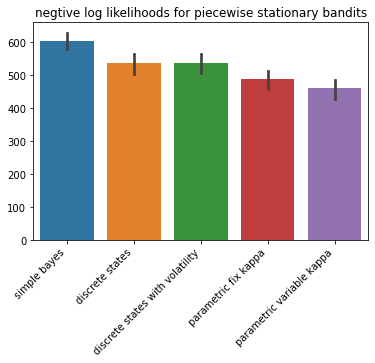

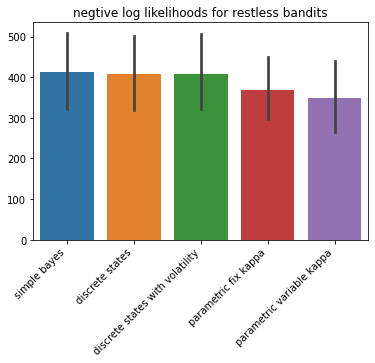

In [12]:
import seaborn as sns

log_likes_swtch = -np.array(F_swtch).sum(axis=1).T
log_likes_drft = -np.array(F_drft).sum(axis=1).T

f = plt.figure()
g = sns.barplot(data=log_likes_swtch)
plt.title("negtive log likelihoods for piecewise stationary bandits")
g.set_xticklabels(learning_names, rotation=45, horizontalalignment='right')
plt.show()

f = plt.figure()
g = sns.barplot(data=log_likes_drft)
plt.title("negtive log likelihoods for restless bandits")
g.set_xticklabels(learning_names, rotation=45, horizontalalignment='right')
plt.show()